## Full Spectrum Blocked
### from New Data/Spectrum2 blocked/A0034

In [31]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [32]:
# Calibration numbers come from multiple calibrations with proper error analysis and weighted averaging
# Calulations can be found in "Multiple Plot Calibration"
CalM = -5.169066740202884
CalM_err = 1.8472146461547026e-06

# define functions
def LinearFunc(t, a, b):
    return a * t + b

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope):
    return (10 * DriveSlope * CalM * (t - t0))

def Cali_Err(t, t0, t0_err, DriveSlope, DriveSlope_err):
    return np.sqrt( (10 * DriveSlope_err * CalM * (t - t0))**2 +
                    (10 * DriveSlope * CalM_err * (t - t0))**2 +
                    (10 * DriveSlope * CalM * t0_err)**2 )

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, (len(params)-2), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y + x * params[12] + params[13]

50.80612495132868
0.024633512697687505


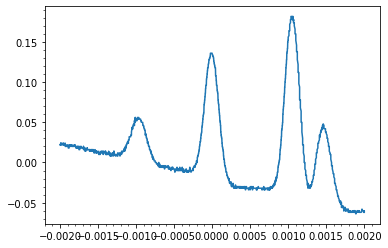

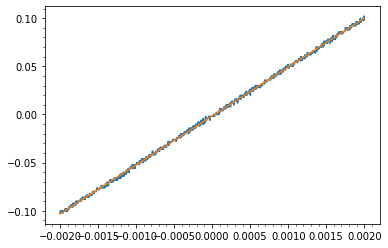

In [38]:
data =  pd.read_csv("New Data/Spectrum2 blocked/A0034CH1.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("New Data/Spectrum2 blocked/A0034CH2.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

#plt.plot(rampx,rampy)



j = 0
for i in x:
    if i == -0.002:
        t1 = j
    if i == 0.002:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

#y = y + 0.333333333*rampy + 0.01

RampGuess = [5, -2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]
print(RampSlope)
print(np.sqrt(RampParam_cov[0,0]))

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()

Y-error = (+/-) 0.0011721875806530925
[-1.84678809e+01 -1.38267820e-02]


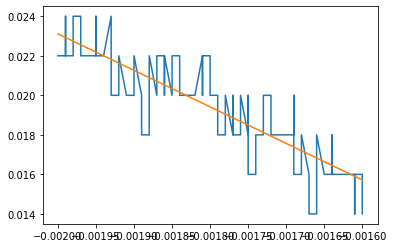

In [43]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == -0.002:
        t1 = j
    if i == -0.0016:
        t2 = j
    j += 1
    
x_back = x[t1:t2]
y_back = y[t1:t2]

Back_guess = [-18,-.014]

Back_popt, Back_pcov = optimize.curve_fit(LinearFunc, x_back, y_back, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_back - LinearFunc(x_back, *Back_popt))**2 ) / (np.size(x_back) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

plt.plot(x_back,y_back)
plt.plot(x_back, LinearFunc(x_back, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

87Rb F=1 Peak Position: 0.0014695498208742992 +/- 3.6114882525202714e-07
Reduced Chi Squared = 4.2627921422313895


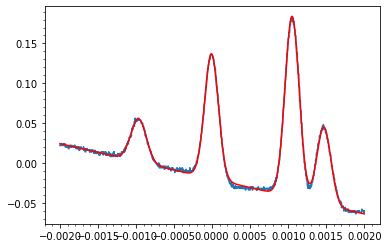

Reduced Chi Squared = 4.26279214421285


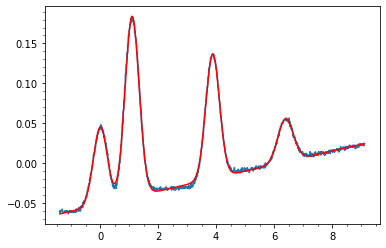

87Rb F=2 Seperation: 3.5724119449984926e-07 +/- 0.0009461251098250933
87Rb F=2 FWHM: -0.34012578000723087 +/- 0.0014633773380321603
85Rb F=3 Seperation: 1.098581750648966 +/- 0.00040764351839844555
85Rb F=3 FWHM: 0.34400186312415604 +/- 0.0006146639641060534
85Rb F=2 Seperation: 3.8802342726671726 +/- 0.0005787319761126283
85Rb F=2 FWHM: 0.33469614437619816 +/- 0.0008500118711375654
87Rb F=1 Seperation: 6.396506068552192 +/- 0.0017813169272468214
87Rb F=1 FWHM: 0.3761996885439347 +/- 0.0026526212653733344


In [40]:
# Fit curve, apply Calibration, fit again

guess = [-0.001, 0.05000, 0.00020, 0.0, 0.15000, 0.00020, 0.001, 0.21000, 0.00020, 0.0015, 0.05000, 0.00020, -18, -.0138]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=150000)
fit = func(x, *popt)

print("87Rb F=1 Peak Position: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()


# Calibration
Calx = Cali(x, popt[9], RampSlope)

Cguess = [0.0, 0.05000, 0.606, 1.136, 0.15, 0.541, 4.044, 0.20, 0.524, 6.518, 0.05, 0.559, 0, 0]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, Calx, y, p0=Cguess, maxfev=150000)
fit = func(Calx, *popt)
RCS = RdChiSqrd(y, func(Calx, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(Calx, y)
plt.plot(Calx, fit , 'r-')
plt.minorticks_on()
plt.show()

print("87Rb F=2 Seperation: " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0,0])) )
print("87Rb F=2 FWHM: " + str(popt[2]) + " +/- " + str(np.sqrt(pcov[2,2])) )
print("85Rb F=3 Seperation: " + str(popt[3]) + " +/- " + str(np.sqrt(pcov[3,3])) )
print("85Rb F=3 FWHM: " + str(popt[5]) + " +/- " + str(np.sqrt(pcov[5,5])) )
print("85Rb F=2 Seperation: " + str(popt[6]) + " +/- " + str(np.sqrt(pcov[6,6])) )
print("85Rb F=2 FWHM: " + str(popt[8]) + " +/- " + str(np.sqrt(pcov[8,8])) )
print("87Rb F=1 Seperation: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
print("87Rb F=1 FWHM: " + str(popt[11]) + " +/- " + str(np.sqrt(pcov[11,11])) )

Reduced Chi Squared = 4.262792147964833


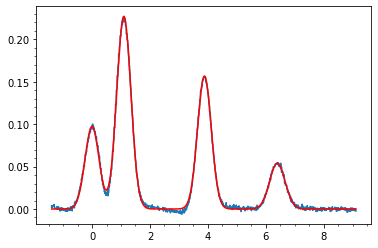

87Rb F=2 Seperation: -8.941859069692079e-07 +/- 0.0009483239677676446
87Rb F=2 FWHM:       -0.3401281029338544 +/- 0.001463532405160078
85Rb F=3 Seperation: 1.098581830076578 +/- 0.00040768034938791763
85Rb F=3 FWHM:       0.3440019447175934 +/- 0.0006146164594146701
85Rb F=2 Seperation: 3.880234210343116 +/- 0.0005787281193161015
85Rb F=2 FWHM:       0.33469640113588683 +/- 0.0008498958943023153
87Rb F=1 Seperation: 6.396505930877502 +/- 0.0017813085872221592
87Rb F=1 FWHM:       0.37619948421143823 +/- 0.002652600016537971


In [42]:
#Flattens
yFlat = y - LinearFunc(Calx, popt[12], popt[13])

CFlatguess = [0.0, 0.05000, 0.606, 1.136, 0.15, 0.541, 4.044, 0.20, 0.524, 6.518, 0.05, 0.559, 0, 0]
# position, amplitude, width

Fpopt, Fpcov = optimize.curve_fit(func, Calx, yFlat, p0=CFlatguess, maxfev=150000)
fit = func(Calx, *Fpopt)
RCS = RdChiSqrd(yFlat, func(Calx, *Fpopt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(Calx, yFlat)
plt.plot(Calx, fit , 'r-')
plt.minorticks_on()
plt.show()

print("87Rb F=2 Seperation: " + str(Fpopt[0]) + " +/- " + str(np.sqrt(Fpcov[0,0])) )
print("87Rb F=2 FWHM:       " + str(Fpopt[2]) + " +/- " + str(np.sqrt(Fpcov[2,2])) )
print("85Rb F=3 Seperation: " + str(Fpopt[3]) + " +/- " + str(np.sqrt(Fpcov[3,3])) )
print("85Rb F=3 FWHM:       " + str(Fpopt[5]) + " +/- " + str(np.sqrt(Fpcov[5,5])) )
print("85Rb F=2 Seperation: " + str(Fpopt[6]) + " +/- " + str(np.sqrt(Fpcov[6,6])) )
print("85Rb F=2 FWHM:       " + str(Fpopt[8]) + " +/- " + str(np.sqrt(Fpcov[8,8])) )
print("87Rb F=1 Seperation: " + str(Fpopt[9]) + " +/- " + str(np.sqrt(Fpcov[9,9])) )
print("87Rb F=1 FWHM:       " + str(Fpopt[11]) + " +/- " + str(np.sqrt(Fpcov[11,11])) )